## Feature Extraction toolbox

In [1]:
#establishing environment
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import pickle
import scipy
from scipy.stats import pearsonr, ttest_rel, ttest_ind
from scipy import signal as sig
import matplotlib.patches as mpatches
import mat73
from scipy.io import loadmat, savemat
import mne
#conda install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session
import random
from sklearn.cluster import KMeans

In [2]:
def prep_clean_soz(SOZ_ch_labels):
    """ 
    function will clean the SOZ labels for each patient.
    input: SOZ_ch_labels from load pt data function. 
    output: list of cleaned names for each patient --> essentially adds '-CAR' to the end of each label.
    """
    clean_soz_labels = []
    for i in range(len(SOZ_ch_labels)):
        labels = SOZ_ch_labels.iloc[i]
        labels_to_list = [x for x in labels]
        if type(labels_to_list[0]) == str:
            labels_squish = labels_to_list[0].replace(" ","")
            labels_split = labels_squish.split(',')
            clean_labels_per_pt = [x+'-CAR' for x in labels_split]
            clean_soz_labels.append(clean_labels_per_pt)
        else: 
            clean_soz_labels.append('SOZ not defined')

    return clean_soz_labels

def load_pt(ptname, data_directory):
    """
    input: ptname, a string containing the name of the patient you want to load. example: 'HUP100'
    output: object: spike ---- contains: List of 1000 random spikes: spike.select   and their subsequent:
    values: spike.values, chlabels: spike.chlabels, fs: spike.fs, soz channels: spike.soz
    """        

    val = mat73.loadmat(data_directory + '/values/values_{}.mat'.format(ptname))
    val2 = val['values_all']
    select_spikes = loadmat(data_directory + '/randi/randi_{}.mat'.format(ptname))
    select_spikes = select_spikes['select_spikes']
    ch_labels = loadmat(data_directory + '/chlabels/chlabels_{}.mat'.format(ptname))
    ch_labels = ch_labels['ch_labels_all']
    fs_all = loadmat(data_directory + '/fs/fs_{}.mat'.format(ptname))
    fs_all = fs_all['fs_all']
    SOZ_chlabels = pd.read_csv(data_directory + '/pt_data/SOZ_channels.csv')
    pt_all = pd.read_csv('/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Patient/pt_database/pt_data/ptname_all.csv')
    ptname = ("'{}'".format(pt_name))
    whichpt = pt_all.index[pt_all['ptname'] == ptname].tolist()
    clean_SOZ_chlabels = prep_clean_soz(SOZ_chlabels)
    
    class spike:
        values = val2
        select=select_spikes
        chlabels = ch_labels
        fs = fs_all
        soz = clean_SOZ_chlabels[whichpt[0]]

    return spike

In [3]:
data_directory = '/Users/carlosaguila/Downloads'
pt_name = 'HUP100'
spike = load_pt(pt_name,data_directory)

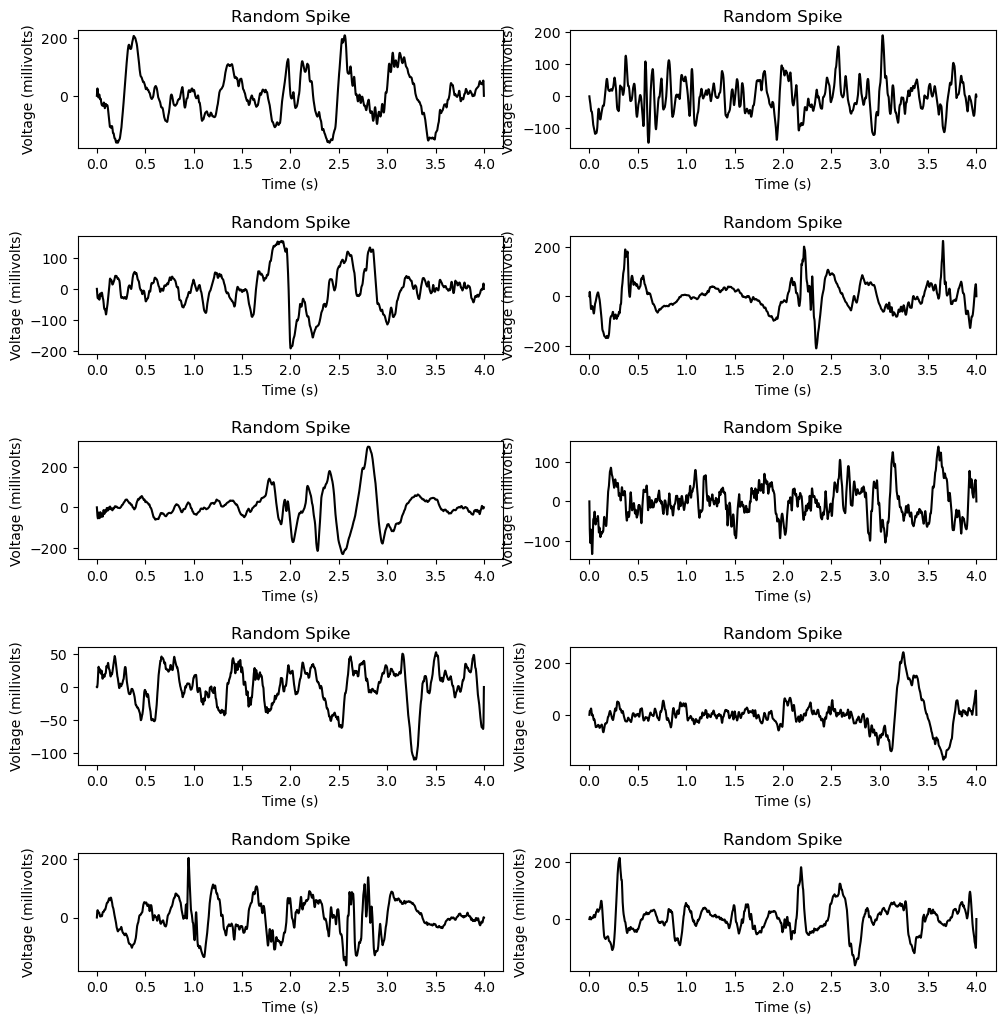

In [4]:
#function that takes random value matrix and plots
def plot_rand_spikes(values):
    plot_idx = range(5)
    fig, axs = plt.subplots(len(plot_idx), 2, figsize=(10,10))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.74)

    time = np.linspace(0,4,2001)
    for i in plot_idx:
        
        choice1 = random.choice(range(len(values))) #picks from what run_time to pull from
        choice2 = random.choice(np.transpose(values[choice1])) #picks what spike to plot in run_time
        
        choice3 = random.choice(range(len(values))) #picks from what run_time to pull from
        choice4 = random.choice(np.transpose(values[choice3])) #picks what spike to plot in run_time
        
        axs[i,0].plot(time, choice2, 'k') #plot nerve data - unfiltered
        axs[i,0].set_ylabel("Voltage (millivolts)")
        axs[i,0].set_xlabel("Time (s)")
        axs[i,0].set_title("Random Spike")
        
        axs[i,1].plot(time, choice4,'k') #plot new axs. 
        axs[i,1].set_ylabel("Voltage (millivolts)")
        axs[i,1].set_xlabel("Time (s)")
        axs[i,1].set_title("Random Spike")

    return

plot_rand_spikes(spike.values)

217


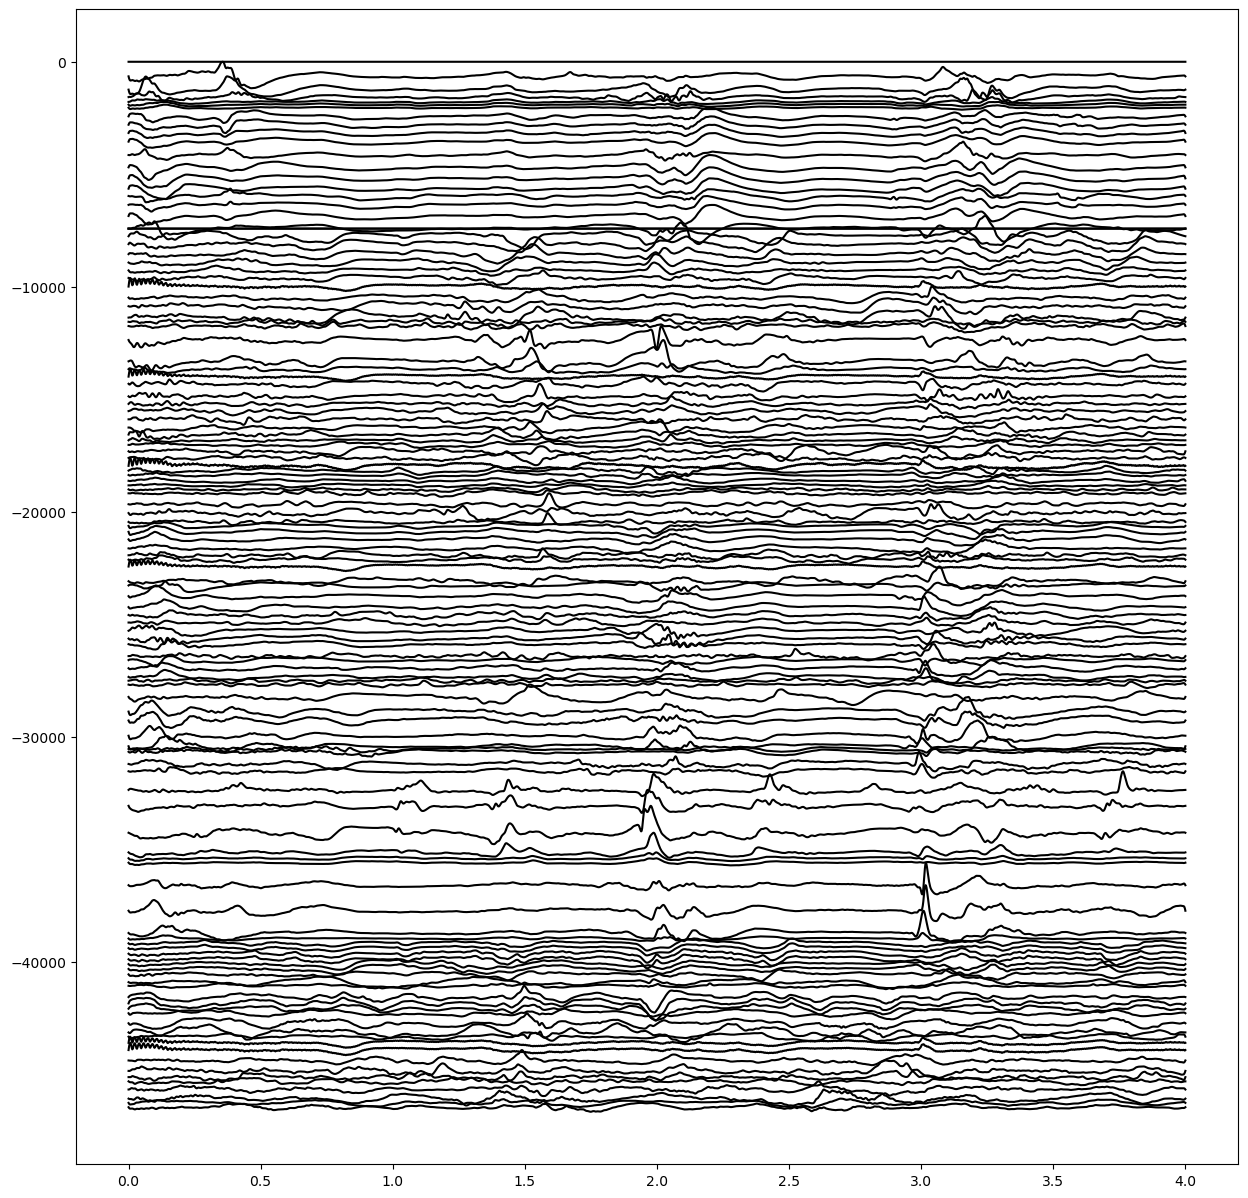

In [5]:
#function that takes random matrix, and plots down the channels
def plot_rand_eeg(values):
    set = random.choice(range(len(values)))
    values_for_all = (values[set])
    time = np.linspace(0,4,np.size(values_for_all,0))
    offset = 0
    plt.figure(figsize = (15,15))

    for i in range(np.size(values_for_all,1)):
        values_per_ch = values_for_all.transpose()
        plot_values = values_per_ch[i]
        val = plot_values.flatten()
        val = [0 if math.isnan(x) else x for x in val]
        offset = offset + np.max(val)
        plt.plot(time, val - offset,'k')
    
    return set


print(plot_rand_eeg(spike.values))

304


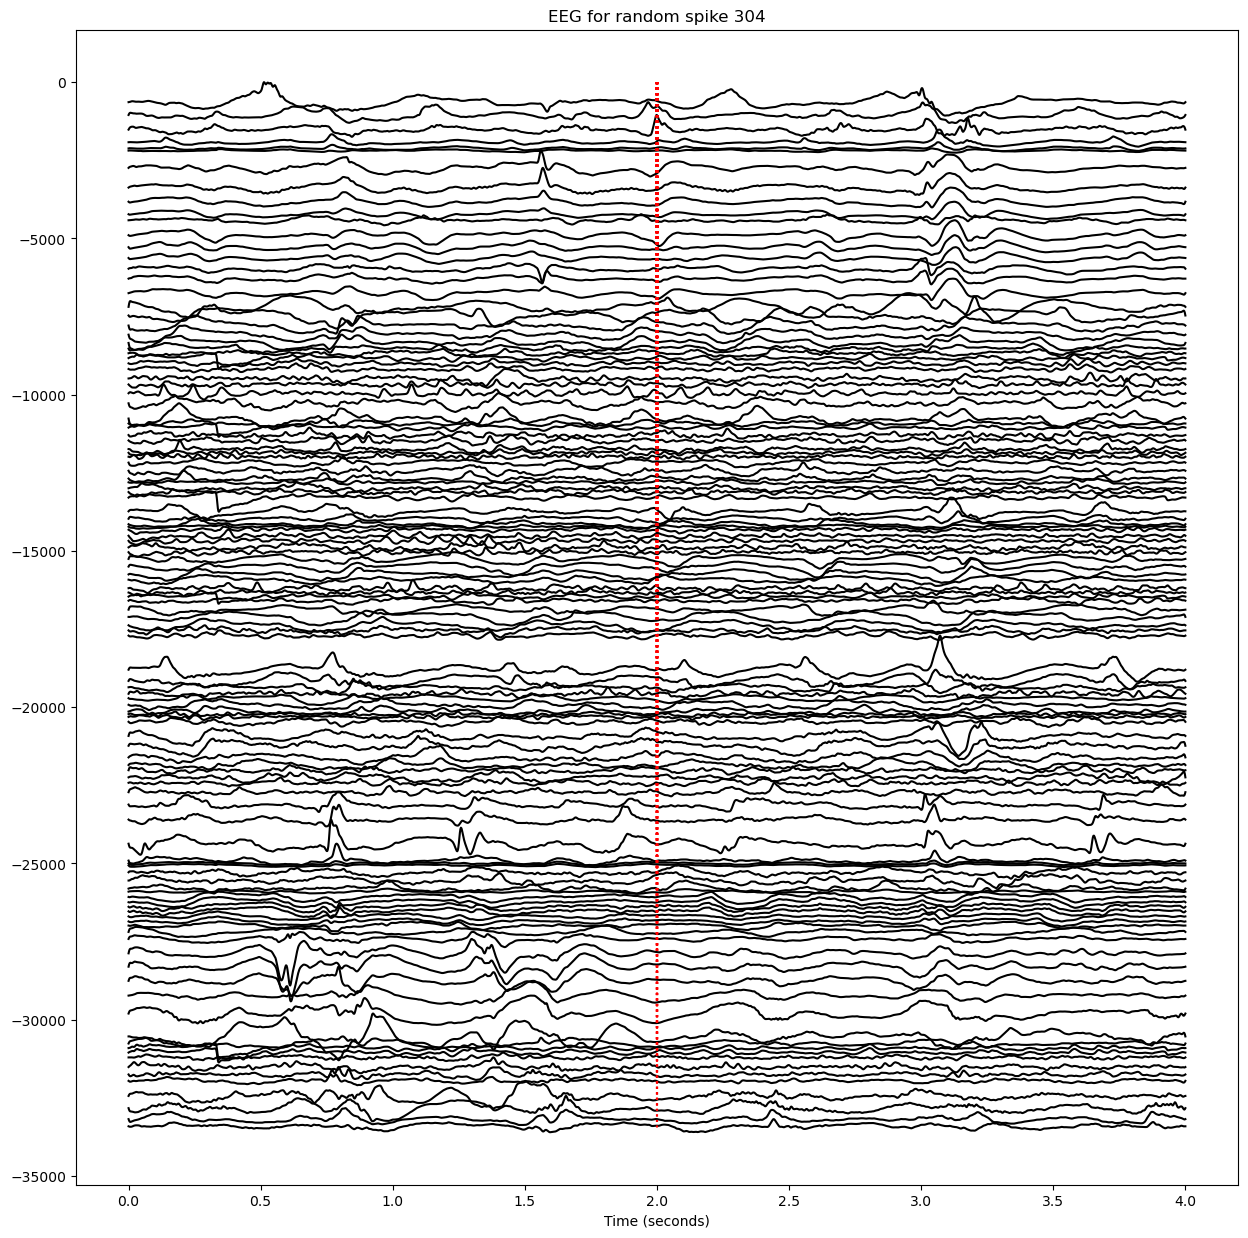

In [6]:
#function that takes random matrix, and plots down the channels
def plot_eeg(values, set):
    values_for_all = (values[set])
    time = np.linspace(0,4,np.size(values_for_all,0))
    offset = 0
    plt.figure(figsize = (15,15))

    for i in range(np.size(values_for_all,1)):
        values_per_ch = values_for_all.transpose()
        plot_values = values_per_ch[i]
        val = plot_values.flatten()
        if math.isnan(np.mean(val)) == True:
            continue
        #val = [0 if math.isnan(x) else x for x in val]
        offset = offset + np.max(val)
        plt.plot(time, val - offset,'k')
        plt.title('EEG for random spike {}'.format(set))
        plt.xlabel('Time (seconds)')
        plt.vlines(2,0,-offset-100,colors='r',linestyles='dotted')
    
    return set

print(plot_eeg(spike.values,304))

In [7]:
# line length
def LL(x):
    return np.sum(np.absolute(np.ediff1d(x)))

# energy
def E(x):
    return np.sum(x ** 2)

#RMS
def RMS(x):
    return np.sqrt(np.mean(x**2))

# area
def A(x):
    return np.sum(np.absolute(x))

# spectral amp
def spectral_amplitude(x):
    x_fft = np.fft.fft(x)
    return np.mean(x_fft)

def mean_amplitude_freq(X, fs, lF, uF):
    time_step = 1/fs
    ps = np.abs(np.fft.fft(X)) ** 2
    freqs = np.fft.fftfreq(X.size, time_step)
    mask = np.logical_and(freqs >= lF, freqs <= uF )
    avgValue = ps[mask].mean()
    return avgValue

# number of crossings (zero) - not in
def ZX(x):
    x_demean = x - np.mean(x)
    num_crossings = 0
    for i in range(1, len(x)):
        fromAbove = False
        fromBelow = False
        if x_demean[i - 1] > 0 and x_demean[i] < 0:
            fromAbove = True
        if x_demean[i - 1] < 0 and x_demean[i] > 0:
            fromBelow = True

        if fromAbove or fromBelow:
            num_crossings += 1
    return num_crossings

def MEAN(x):
    return np.mean(x)

def bandpower(x, fs, fmin, fmax):
    f, Pxx = sig.periodogram(x, fs=fs)
    ind_min = np.argmax(f > fmin) - 1
    ind_max = np.argmax(f > fmax) - 1
    return np.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

In [8]:
#function to apply feature extraction to a single matrix
def create_feat_list(values):
    feats = []
    for val in values:
        feat_per_spike = []
        val_t = val.transpose()
        for list in val_t:
            list = [0 if math.isnan(x) else x for x in list]
            maxes = np.max(np.absolute(list[750:1251])) #calculate max values around peak
            linelen = LL(list)
            area = A(list)
            feat_per_spike.append([maxes,linelen, area])
        feats.append(feat_per_spike)
    
    return feats

In [9]:
feats = create_feat_list(spike.values)

In [10]:
print(np.shape(feats))

(1000, 125, 3)


In [11]:
def find_spike_ch(select_spikes,values):
    #this function will find the values for the spiking channel.
    #should return a 1000 x #ofsamples matrix

    select_spikes_ch = []
    for spikes in select_spikes:
        ch = spikes[1]
        ch = int(ch)-1
        select_spikes_ch.append(ch)
    
    spike_value_all = []
    for i in range(np.size(values,0)):
        val = values[i]
        val_t = val.transpose()
        spike_value = val_t[select_spikes_ch[i]]
        spike_value_all.append(spike_value)

    return select_spikes_ch, spike_value_all #list of spiking channels, list of values for each spiking channel.

In [12]:
select_spikes_ch, spike_value_all = find_spike_ch(spike.select,spike.values)

In [13]:
print(np.shape(spike_value_all))
print(np.shape(random.choice(spike_value_all)))

(1000, 2001)
(2001,)


In [14]:
#function that takes random value matrix and plots
def plot_rand_onlyspikes(values,select_spikes):
    select_spikes_ch, spike_value_all = find_spike_ch(select_spikes,values)

    plot_idx = range(5)
    #fig, axs = plt.subplots(len(plot_idx), 2, figsize=(10,10))
    #fig.tight_layout()
    #fig.subplots_adjust(hspace=0.74)

    time = np.linspace(0,4,2001)
    columns = 5
    rows = 10
    fig, ax_array = plt.subplots(rows,columns, squeeze=True,figsize=(40,40),dpi=80)
    fig.subplots_adjust(hspace=0.74)
    for i, ax_row in enumerate(ax_array):
        for j, axes in enumerate(ax_row):
            choice=random.choice(spike_value_all)
            axes.plot(time, choice, 'k')
            axes.set_title("Random Spike")
            axes.set_ylabel("Voltage (millivolts)")
            axes.set_xlabel('Time (s)')

    for i in plot_idx:
        continue
        
        choice1 = (random.choice(spike_value_all)) #picks from what run_time to pull from
        
        choice3 = (random.choice(spike_value_all)) #picks from what run_time to pull from
        
        axs[i,0].plot(time, (choice1), 'k') #plot nerve data - unfiltered
        axs[i,0].set_ylabel("Voltage (millivolts)")
        axs[i,0].set_xlabel("Time (s)")
        axs[i,0].set_title("Random Spike")
        
        axs[i,1].plot(time, (choice3),'k') #plot new axs. 
        axs[i,1].set_ylabel("Voltage (millivolts)")
        axs[i,1].set_xlabel("Time (s)")
        axs[i,1].set_title("Random Spike")

    return fig

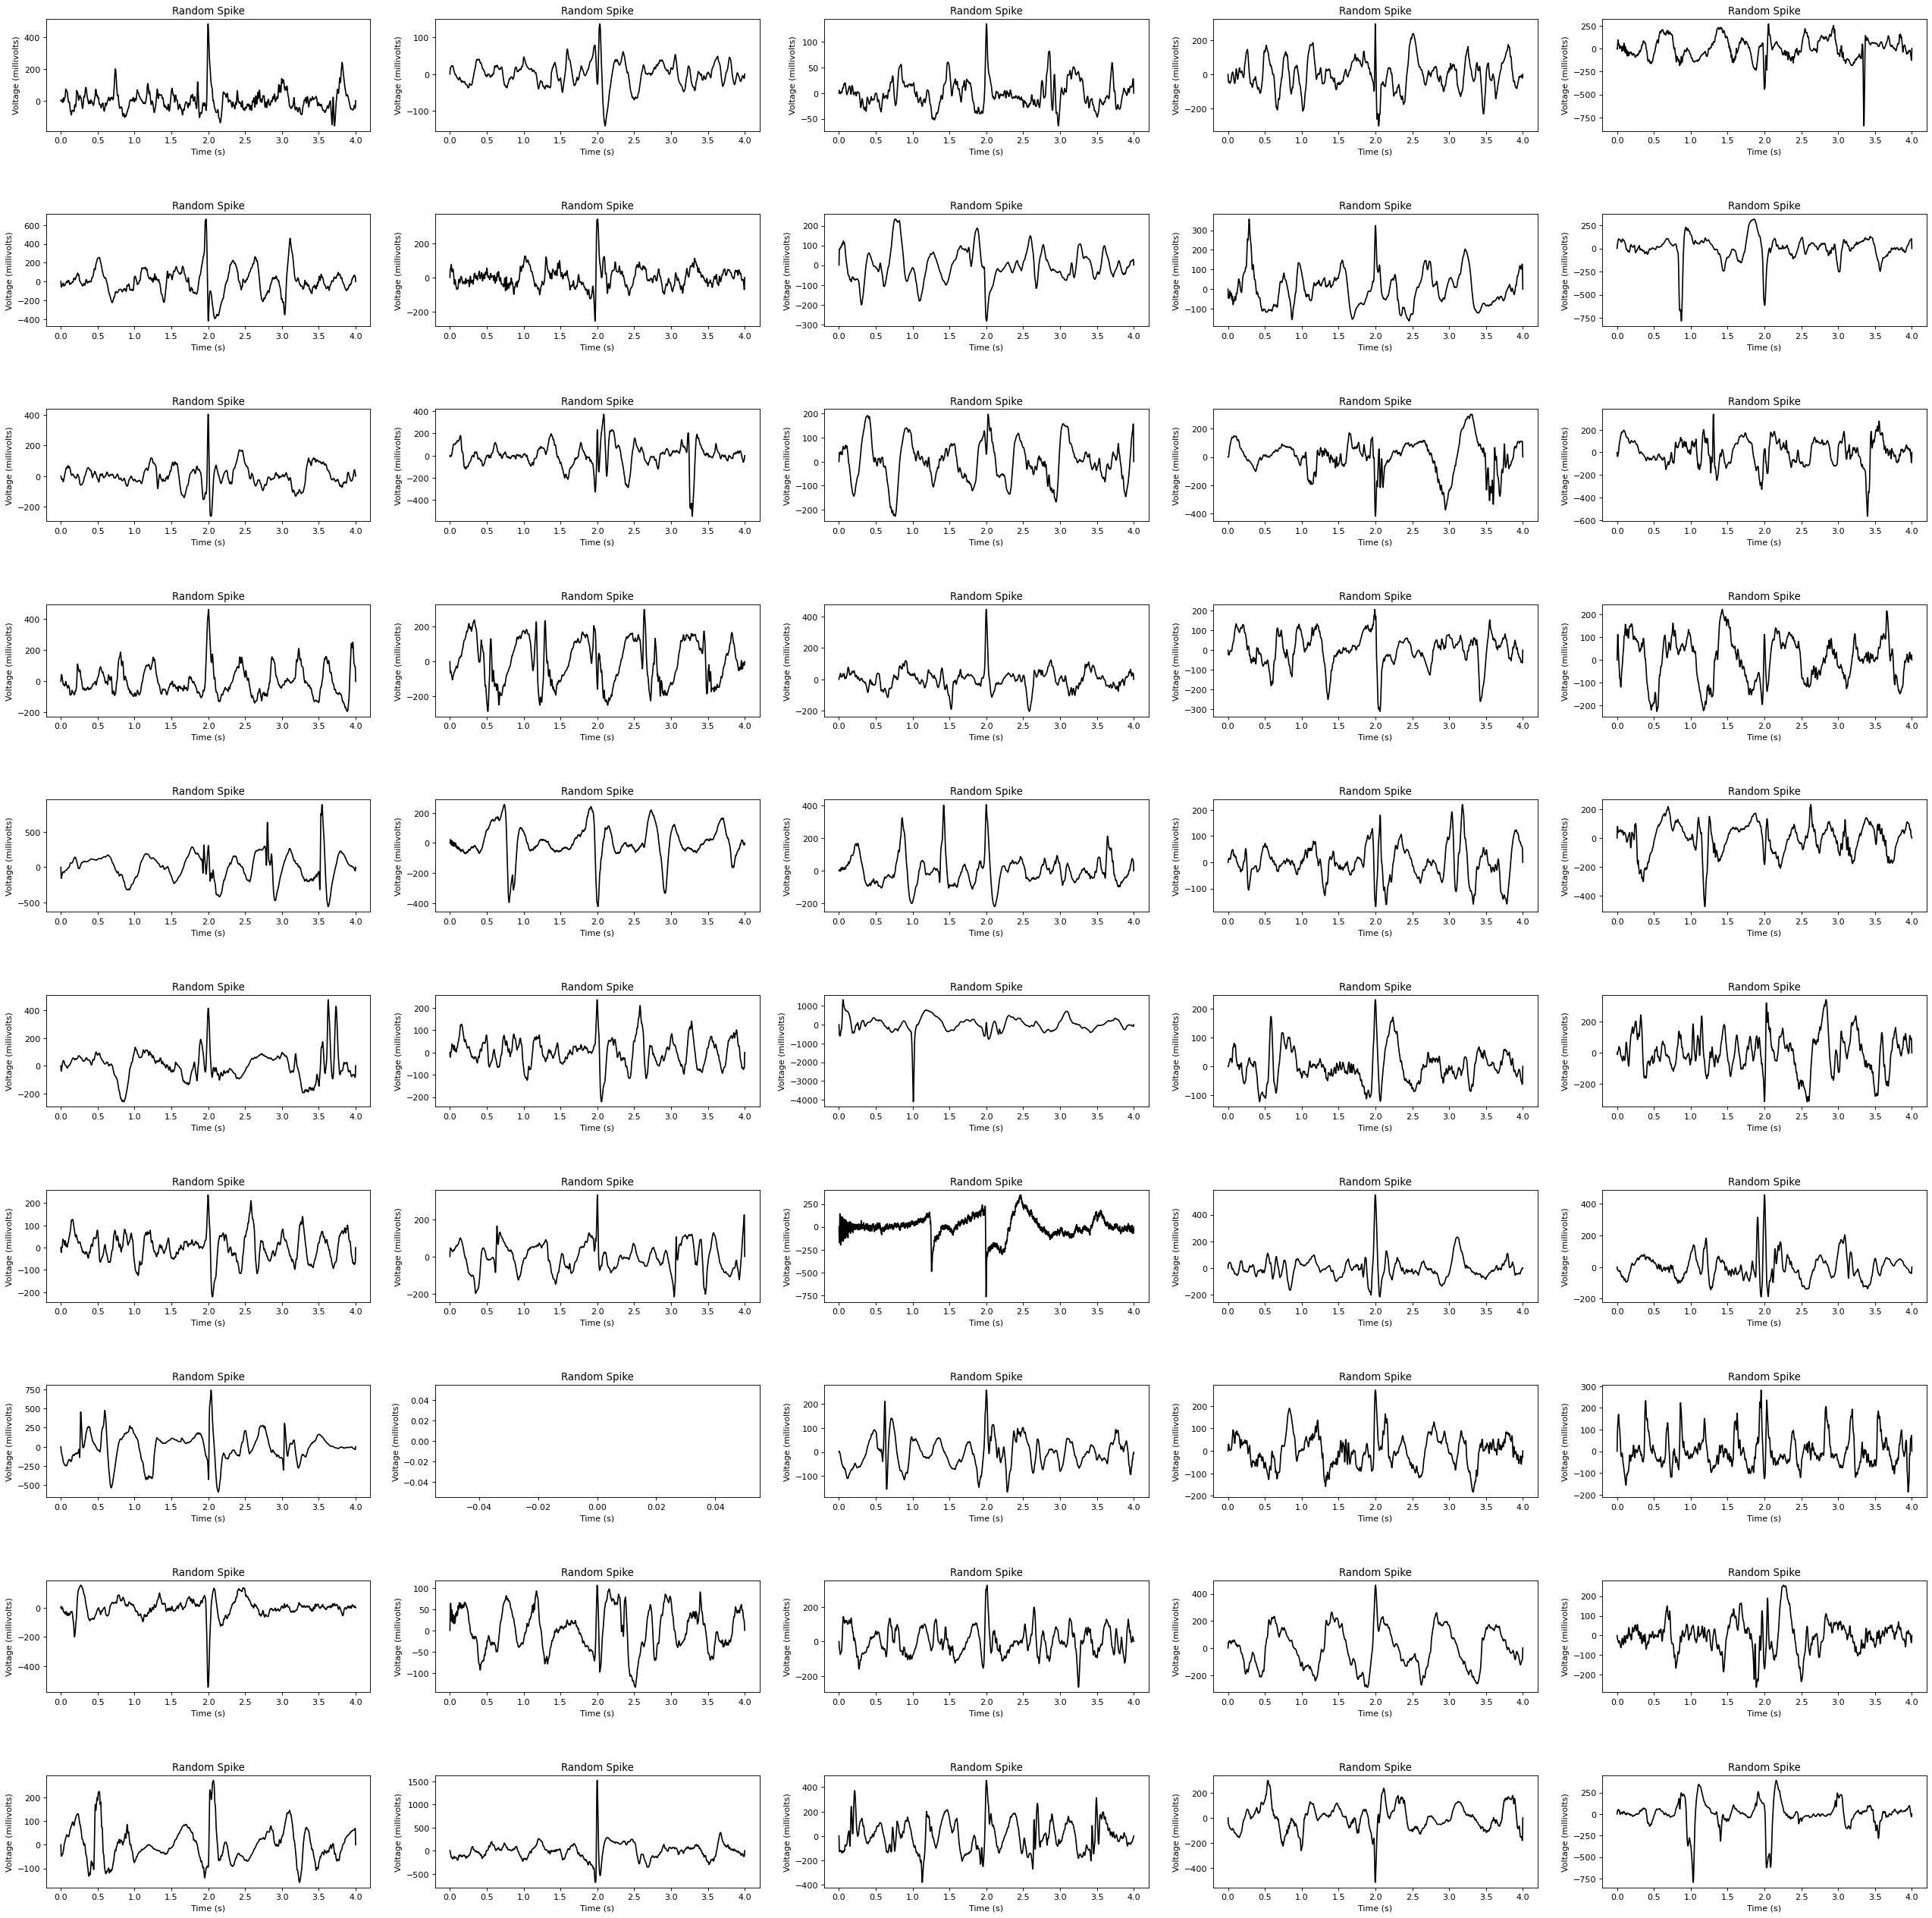

In [15]:
fig3 = plot_rand_onlyspikes(spike.values,spike.select)

In [16]:
#dataframe with all the ptnames and their subsequent whichPts
pt_all = pd.read_csv('/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Patient/pt_database/pt_data/ptname_all.csv')
display(pt_all)
x = (pt_all['ptname'].iloc[1])
ptname2 = ("'{}'".format(pt_name))
yo = pt_all.index[pt_all['ptname'] == ptname2].tolist()
yo2 = pt_all.iloc[yo]
print(yo)
print('---------------------------')
print(yo2)

whichPts    ptname
0           1  'HUP100'
1           2  'HUP101'
2           3  'HUP102'
3           4  'HUP105'
4           5  'HUP106'
..        ...       ...
114       115  'HUP219'
115       116  'HUP221'
116       117  'HUP223'
117       118  'HUP224'
118       119  'HUP225'

[119 rows x 2 columns]

[0]
---------------------------
   whichPts    ptname
0         1  'HUP100'


In [17]:
def hifreq_ch_spike(select_spikes):
    """ 
    function to find the frequency of spiking for a unique channel
    input: 1000 random spike file (randi)
    output: 2x1 list containing the unique channels[0] and the frequency in which they are spiking [1]
    """

    spiking_ch = [] #create list of spiking channels from spike.select (1000 random spikes)
    for spike in select_spikes:
        spiking_ch.append(spike[1])

    uniq_chs = np.unique(spiking_ch) #generate unique channels

    counts=[] #find the frequency
    for ch in uniq_chs:
        x = spiking_ch.count(ch)
        counts.append(x)

    total = 0 #sanity check - the frequency of ch's should add up to 1000
    for ele in range(0, len(counts)):
        total = total + counts[ele]
    if total != 1000:
        print('not working correct')

    spiking_chs = [int(x) for x in spiking_ch]

    return [uniq_chs, counts], spiking_chs

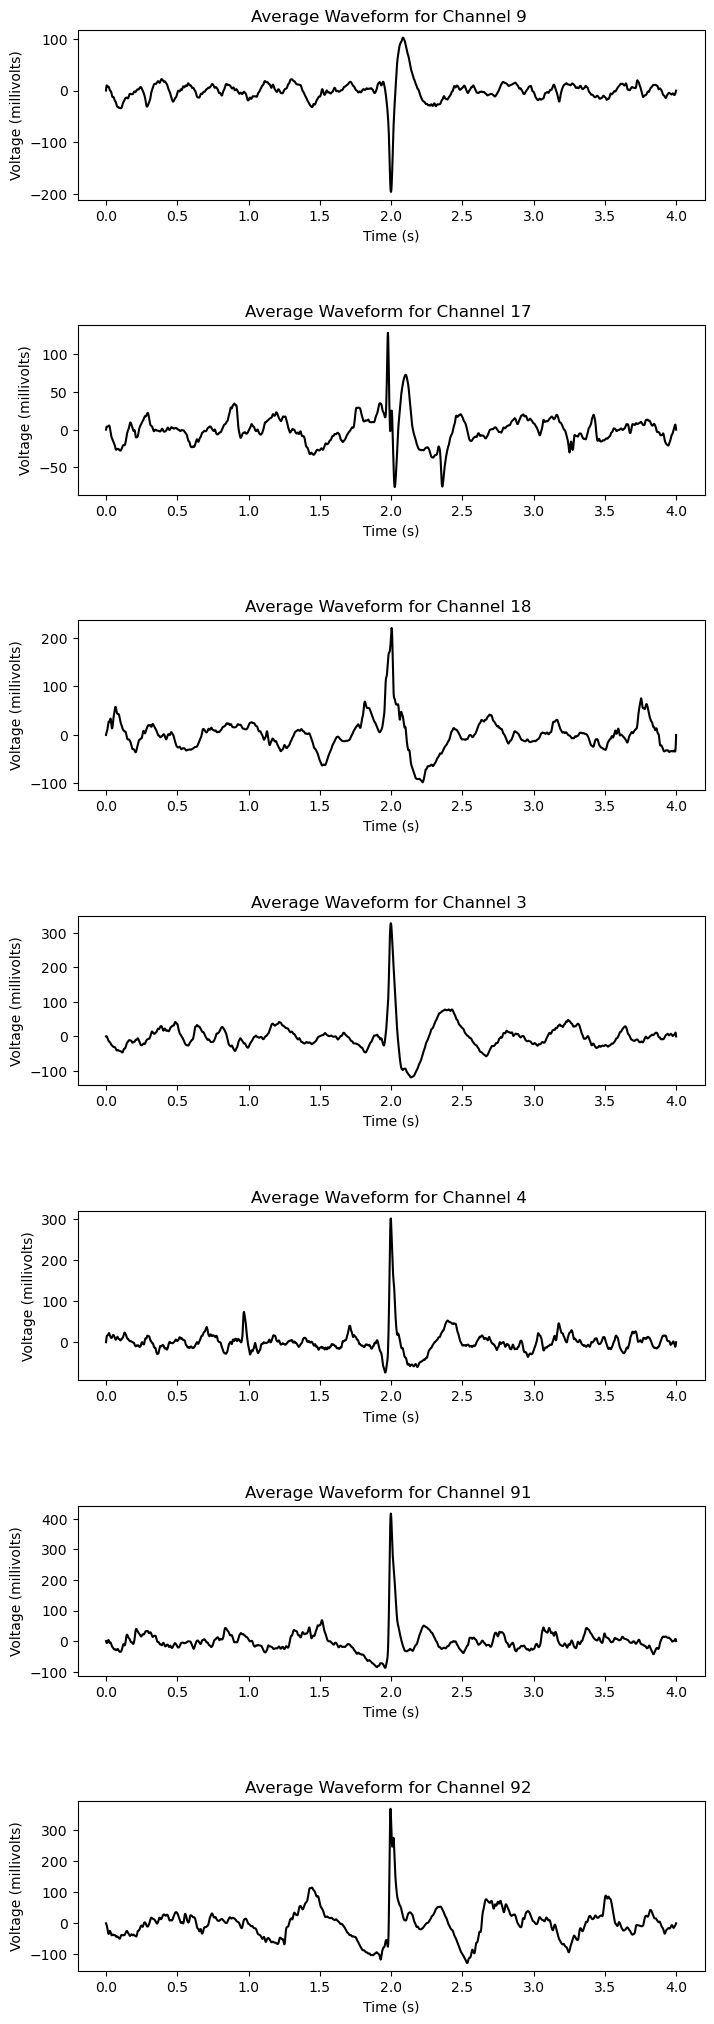

In [18]:
#work for the function: average_waveform_hifreq

counts, chs = hifreq_ch_spike(spike.select)
sorted_counts = np.sort(counts[1])
x = sorted_counts[-1]
y = sorted_counts[-5:-1]
high_freq_count = np.append(y,x) #finds the highest spiking counts

loc_high_counts = []
for i in range(len(high_freq_count)):
    loc_high_counts.append((np.where(counts[1] == high_freq_count[i])[0]))
loc_high_counts = (np.concatenate(loc_high_counts)) #find where the highest spiking counts are located.

high_chs = counts[0][loc_high_counts] #find the channel number of the highest spiking count.

#index of the channel with highest freq, from the 1000 spikes
idx_of_all_chs = []
for ch in high_chs:
    idx_of_all_chs.append(np.where(chs == ch)[0])
#idx_of_all_chs = np.concatenate(idx_of_all_chs) 

#find the average waveform for each spike.chlabels
waveforms = []
for i in range(len(high_chs)):
    spike_at_ch = []
    for spike_x in idx_of_all_chs[i]:
        spike_xs = (spike.values[spike_x])
        spike_fix = spike_xs[:,int(high_chs[i])-1]
        spike_at_ch.append(spike_fix)
    waveforms.append(spike_at_ch)

avg_waveforms = []
for waves in waveforms:
    avg_waveforms.append(np.mean(waves,axis=0))

fig, axs = plt.subplots(len(avg_waveforms), 1, figsize=(7,20))
fig.tight_layout()
fig.subplots_adjust(hspace=0.74)
time = np.linspace(0,4,2001)
for i in range(len(waveforms)):
    axs[i].plot(time, avg_waveforms[i], 'k') #plot nerve data - unfiltered
    axs[i].set_ylabel("Voltage (millivolts)")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_title("Average Waveform for Channel {} ".format(int(high_chs[i])))

In [19]:
def average_waveform_hifreq(spike_select, spike_values):
    """
    This function serves to find channel which created the most spikes and plot their average waveform
    input: 1000 random spikes file and the corresponding values
    output: figure with the average waveform, and a list with the average waveform of the top 5 highest frequent channels (if theres ties, it adds more channels)
    """

    counts, chs = hifreq_ch_spike(spike_select)
    sorted_counts = np.sort(counts[1])
    x = sorted_counts[-1]
    y = sorted_counts[-5:-1]
    high_freq_count = np.append(y,x) #finds the highest spiking counts

    loc_high_counts = []
    for i in range(len(high_freq_count)):
        loc_high_counts.append((np.where(counts[1] == high_freq_count[i])[0]))
    loc_high_counts = (np.concatenate(loc_high_counts)) #find where the highest spiking counts are located.

    high_chs = counts[0][loc_high_counts] #find the channel number of the highest spiking count.

    #index of the channel with highest freq, from the 1000 spikes
    idx_of_all_chs = []
    for ch in high_chs:
        idx_of_all_chs.append(np.where(chs == ch)[0])
    #idx_of_all_chs = np.concatenate(idx_of_all_chs) 

    #find the average waveform for each spike.chlabels
    waveforms = []
    for i in range(len(high_chs)):
        spike_at_ch = []
        for spike_x in idx_of_all_chs[i]:
            spike_xs = (spike_values[spike_x])
            spike_fix = spike_xs[:,int(high_chs[i])-1]
            spike_at_ch.append(spike_fix)
        waveforms.append(spike_at_ch)

    #calculate the average
    avg_waveforms = []
    for waves in waveforms:
        avg_waveforms.append(np.mean(waves,axis=0))

    #plot average waveform
    fig, axs = plt.subplots(len(avg_waveforms), 1, figsize=(7,15))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.74)
    time = np.linspace(0,4,2001)
    for i in range(len(waveforms)):
        axs[i].plot(time, avg_waveforms[i], 'k') #plot nerve data - unfiltered
        axs[i].set_ylabel("Voltage (millivolts)")
        axs[i].set_xlabel("Time (s)")
        axs[i].set_title("Average Waveform for Channel {}, Freq = {}/1000".format(int(high_chs[i]), len(waveforms[i])))

    return fig, avg_waveforms


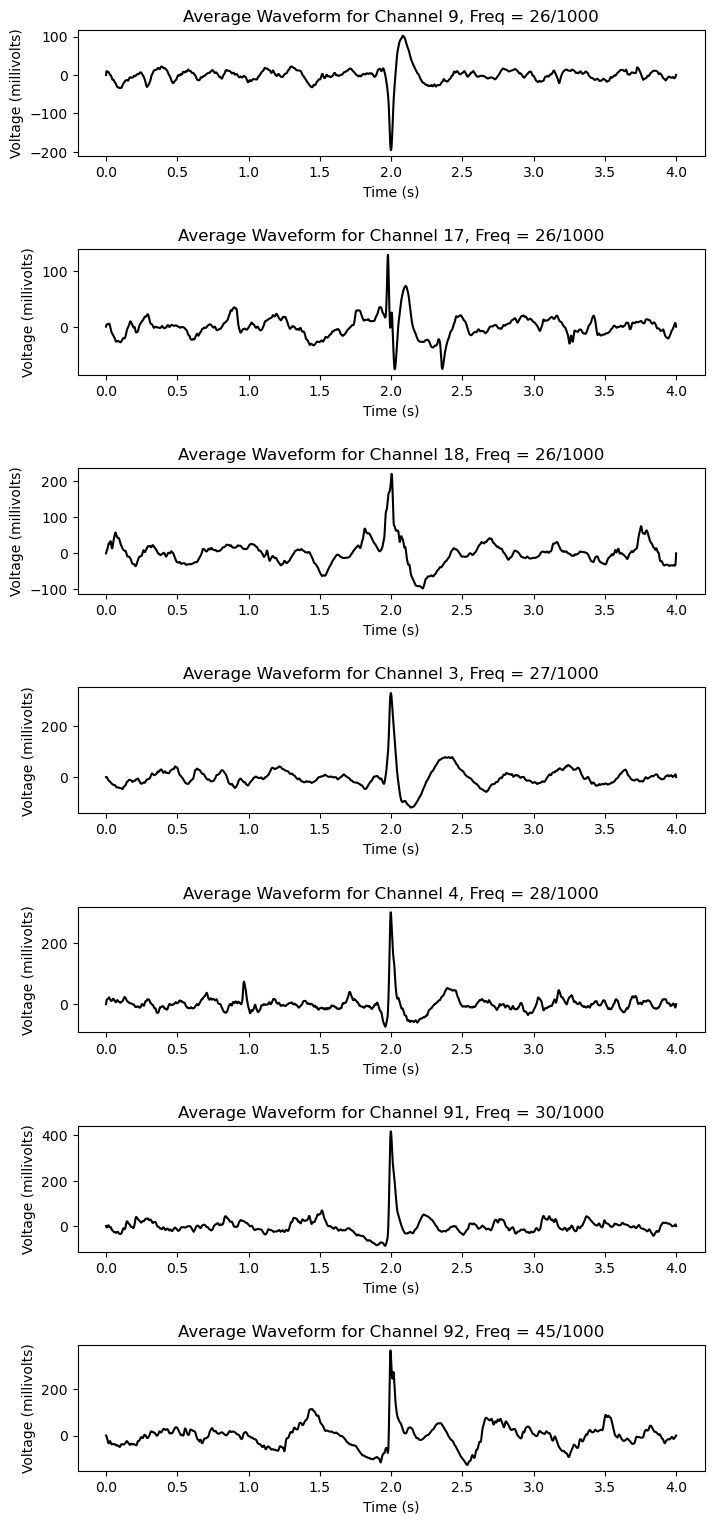

In [20]:
fig, avg_hi_waveforms = average_waveform_hifreq(spike.select, spike.values)

In [21]:
#load patient 100
data_directory = '/Users/carlosaguila/Downloads'
pt_name = 'HUP101'
spike = load_pt(pt_name,data_directory)

In [22]:
spike.soz

['LPF2-CAR',
 'LPF3-CAR',
 'ROF7-CAR',
 'ROF8-CAR',
 'APD1-CAR',
 'APD2-CAR',
 'APD3-CAR',
 'APD4-CAR',
 'PPD1-CAR',
 'PPD2-CAR',
 'PPD3-CAR',
 'PPD4-CAR']

In [23]:
np.shape(spike.chlabels[0][600])

(120, 1)

In [24]:
SOZ_find = np.where(spike.chlabels[0][600] == spike.soz)[0]

In [25]:
SOZ_find #these are indices 0 based, add 1
SOZ_channels = [x+1 for x in SOZ_find]
print(SOZ_find)
print(SOZ_channels)

[  4   5   6   7  55  56  80  81  82  83 106 107]
[5, 6, 7, 8, 56, 57, 81, 82, 83, 84, 107, 108]


In [26]:
spike.chlabels[0][600][SOZ_find]


array([[array(['APD1-CAR'], dtype='<U8')],
       [array(['APD2-CAR'], dtype='<U8')],
       [array(['APD3-CAR'], dtype='<U8')],
       [array(['APD4-CAR'], dtype='<U8')],
       [array(['LPF2-CAR'], dtype='<U8')],
       [array(['LPF3-CAR'], dtype='<U8')],
       [array(['PPD1-CAR'], dtype='<U8')],
       [array(['PPD2-CAR'], dtype='<U8')],
       [array(['PPD3-CAR'], dtype='<U8')],
       [array(['PPD4-CAR'], dtype='<U8')],
       [array(['ROF7-CAR'], dtype='<U8')],
       [array(['ROF8-CAR'], dtype='<U8')]], dtype=object)

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


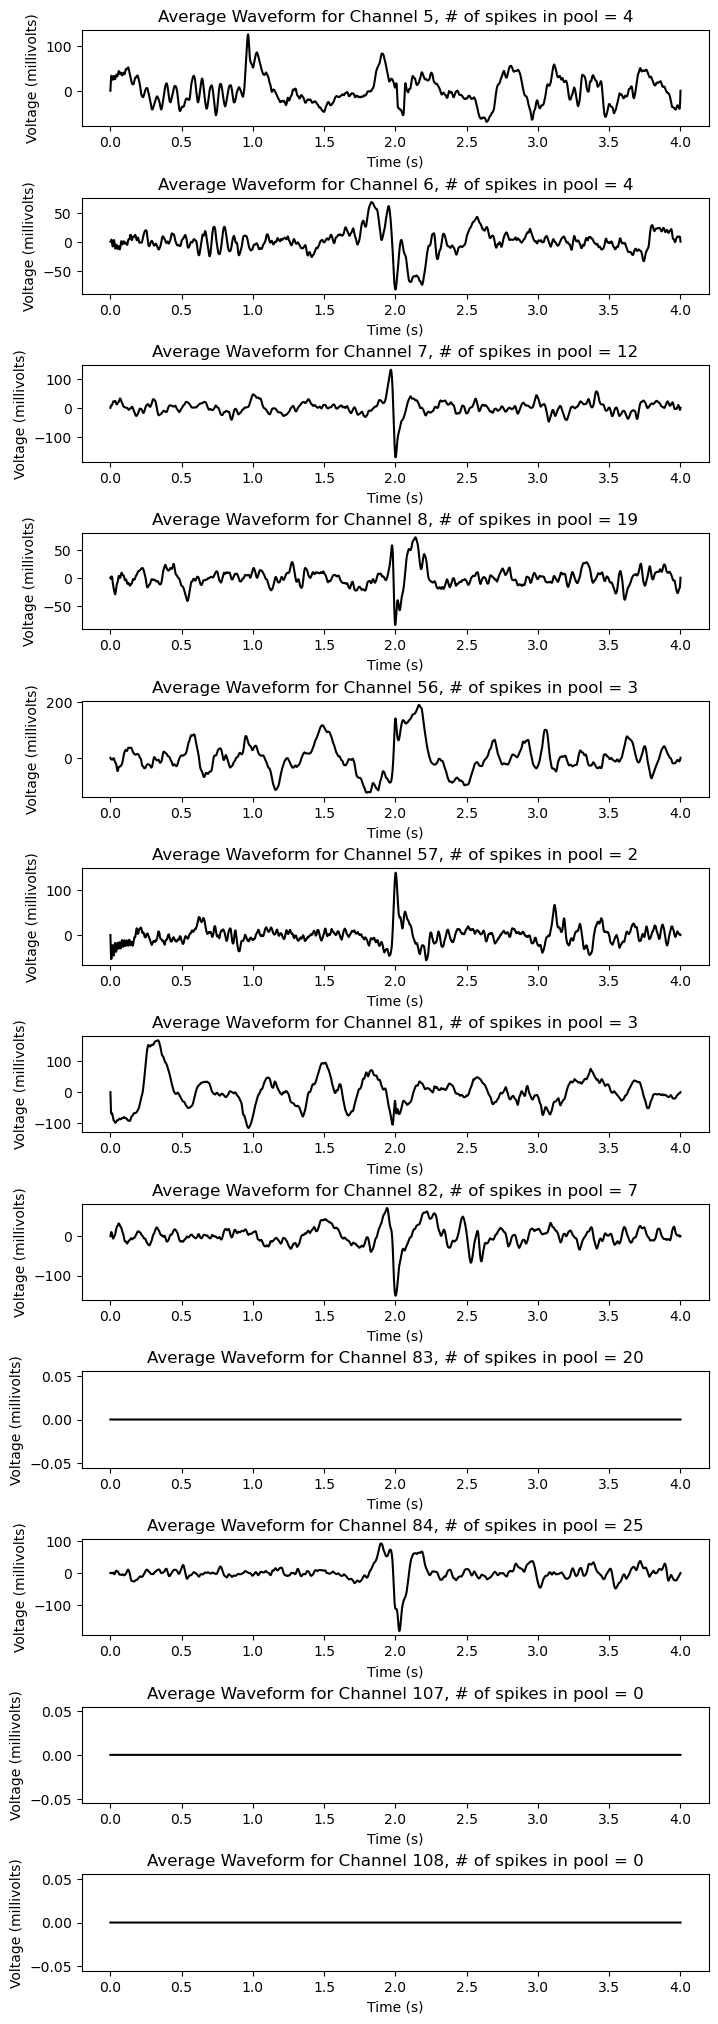

In [27]:
SOZ_spikes = []
for soz in SOZ_channels:
    x = np.where(spike.select[:,1] == soz)[0]
    SOZ_spikes.append(x)
#print((SOZ_spikes))
#print(SOZ_channels)

soz_waveforms = []
for i in range(len(SOZ_spikes)):
    soz_wave = []
    for j in SOZ_spikes[i]:
        soz_spikex = spike.values[j]
        soz_spike_fix = soz_spikex[:,int(SOZ_channels[i])-1]
        soz_wave.append(soz_spike_fix)
    soz_waveforms.append(soz_wave)

avg_sozwaveform = []
for sozwave in soz_waveforms:
    avg_sozwaveform.append(np.mean(sozwave,axis=0))

for i in range(len(avg_sozwaveform)):
    if np.shape(avg_sozwaveform[i]) == ():
        avg_sozwaveform[i] = np.zeros([2001,1])
    elif np.isnan(avg_sozwaveform[i][0]):
        avg_sozwaveform[i] = np.zeros([2001,1])

#plot average waveform
fig, axs = plt.subplots(len(avg_sozwaveform), 1, figsize=(7,20))
fig.tight_layout()
fig.subplots_adjust(hspace=0.74)
time = np.linspace(0,4,2001)
for i in range(len(soz_waveforms)):
    axs[i].plot(time, avg_sozwaveform[i], 'k') #plot nerve data - unfiltered
    axs[i].set_ylabel("Voltage (millivolts)")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_title("Average Waveform for Channel {}, # of spikes in pool = {}".format(int(SOZ_channels[i]), len(SOZ_spikes[i])))

In [28]:
(spike.chlabels[0][501][2][0][0])

#chlabels will get you all the chlabels taking out the fluff
chlabels = []
for label in spike.chlabels[0][500]:
    chlabels.append(label[0][0])

#check if you can detect digits.
x = 'HEL10'
y = []
for yo in x:
    if yo.isdigit() == False:
        y.append(yo)

#print(y)
#print(chlabels)

In [29]:
spike.values[0]

array([[-9.92462644e-03, -2.21535357e-02, -2.79973842e-02, ...,
         9.14073244e-02,  1.31939606e-01,  1.47716408e-01],
       [-1.18578292e+00,  1.41185840e-01, -6.38676958e+00, ...,
        -2.64431188e+00, -1.19262054e+01, -1.01491539e+01],
       [ 1.60617473e+00,  4.17386083e+00, -6.78122542e+00, ...,
         1.54970925e+00, -1.81204485e+01, -1.43033510e+01],
       ...,
       [-7.08489811e+00, -9.26818224e+00, -1.27681868e+00, ...,
         1.22411847e+00, -2.31707782e+01,  8.93199889e+00],
       [-5.05444276e+00, -6.05053793e+00, -1.97584002e+00, ...,
        -6.62072770e-01, -1.32207815e+01,  5.49704547e+00],
       [-2.83029718e-04, -8.16581761e-04,  4.18864489e-03, ...,
         3.94752915e-03,  7.34280216e-04, -3.27431091e-04]])

In [30]:
#kcluster of my 1000 spikes raw to check for any "natural states"
ch_x = range(120)
ch_x = [x+1 for x in ch_x]

values_forone = []
add_label = []
for i in range(len(spike.values)):
    spikel = spike.values[i]
    spikel = spikel.transpose()
    for j in range(len(spikel)):
        combine = [spikel[j],ch_x[j]]
        combine2 = np.hstack(combine)
        add_label.append(combine2)
    values_forone.append(add_label)
    add_label = []
    

values_forone2 = np.concatenate(values_forone,axis=0)

In [31]:
val_df = pd.DataFrame(values_forone2)
val_df2 = val_df.dropna(how='any')

In [32]:
val_df2['mean'] = val_df2.iloc[:,:2001].mean(axis=1)

/var/folders/j3/ps9_bddj0kg0ds3px8t769_00000gn/T/ipykernel_66573/2469438269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df2['mean'] = val_df2.iloc[:,:2001].mean(axis=1)


In [33]:
raw_kmeans = KMeans(n_clusters=2, random_state=24).fit_predict(val_df2.iloc[:,:2001])

In [34]:
filtered_label0 = val_df2[raw_kmeans==0]
filtered_label1 = val_df2[raw_kmeans==1]

In [35]:
filtered_label0

0           1           2           3           4           5  \
2789    0.009563   26.576844   33.223302   12.945108  -24.630532  -59.417774   
2790   -0.035515   30.628207   42.264466   27.767996   -4.793212  -37.543557   
3650    0.081109   -4.141949   -5.217925   -3.622972   -1.791836   -1.584580   
4718    0.042779   36.632729   59.481868   67.089216   65.819163   61.809923   
4727    0.307795   88.454290  144.395283  164.041581  162.196506  153.167548   
...          ...         ...         ...         ...         ...         ...   
104300  1.259929  280.940428  474.906377  568.513583  595.310342  589.833913   
106084  4.454675 -544.848753 -873.613698 -891.270216 -671.710309 -391.879893   
106121 -0.093048   27.528383   43.097659   43.127703   33.367638   22.408036   
107776  0.141656 -190.452368 -317.146132 -322.984402 -205.057056  -49.935998   
111575  0.043262  -19.899012  -35.997722  -45.438187  -46.746282  -41.913520   

                 6           7           8           9  ...        1993  \
2789    -72.511780  -56.921820  -21.352830   14.919977  ...   -9.934599   
2790    -52.923303  -43.025529  -13.387670   20.211611  ...   65.072139   
3650     -3.704651   -7.302254  -10.519588  -11.660948  ...   40.240646   
4718     58.573133   57.061070   56.707361   56.562531  ...  -34.509173   
4727    145.167837  140.985520  140.241766  141.309014  ...  220.181889   
...            ...         ...         ...         ...  ...         ...   
104300  578.864691  581.521885  605.540175  645.542497  ...   42.635151   
106084 -207.447036 -193.676372 -359.111169 -642.004386  ... -188.392054   
106121   15.270553   13.581690   18.260681   28.027890  ...    7.855373   
107776   33.234792   13.783261  -66.575363 -167.237857  ...  817.248997   
111575  -35.412273  -30.880290  -29.741223  -30.335533  ...  -17.713143   

              1994        1995         1996         1997        1998  \
2789    -12.132672  -14.567923   -16.679908   -17.635847  -15.978823   
2790     66.539658   68.730323    71.053063    70.733004   61.883172   
3650     44.439421   49.025114    52.664244    53.531724   47.463628   
4718    -37.454290  -41.480666   -46.072294   -48.795101  -44.698273   
4727    222.698385  228.845141   236.223083   234.811438  205.041916   
...            ...         ...          ...          ...         ...   
104300   42.687586   44.044087    45.934207    46.134006   40.600277   
106084 -228.759690 -239.581499  -215.584319  -191.628580 -172.146623   
106121    7.540824    4.202758    -1.025399    -4.532233   -4.668258   
107776  850.509794  943.187717  1042.813357  1048.237565  891.156594   
111575   -8.909895   -0.592714     5.295402     7.899183    7.693546   

              1999      2000  2001       mean  
2789     -9.974778 -0.001493  18.0   0.186226  
2790     37.890411  0.013209  19.0   0.010997  
3650     29.286004  0.003854  75.0  -1.248978  
4718    -28.141717 -0.006629  51.0   0.344359  
4727    125.370919  0.045899  60.0  -2.979139  
...            ...       ...   ...        ...  
104300   24.944560  0.009760  87.0  -7.603426  
106084 -113.707676  0.000055  59.0 -35.861802  
106121   -2.666595 -0.000180  96.0   0.979621  
107776  531.905388  0.176084  59.0 -12.297205  
111575    4.829394 -0.005268  96.0  -0.573947  

[563 rows x 2003 columns]

In [36]:
filtered_label0.iloc[:,2001]

2789      18.0
2790      19.0
3650      75.0
4718      51.0
4727      60.0
          ... 
104300    87.0
106084    59.0
106121    96.0
107776    59.0
111575    96.0
Name: 2001, Length: 563, dtype: float64

In [37]:
filtered_label1['mean']

0          0.166612
1          0.279437
2          0.363950
3          0.099014
4          0.033082
            ...    
112759    10.877538
112760    -5.218966
112761    -3.357233
112762    -3.532737
112763    -4.314385
Name: mean, Length: 105679, dtype: float64

Text(0.5, 1.0, 'KMEANS: n = 112763, using all channels in every detected spike')

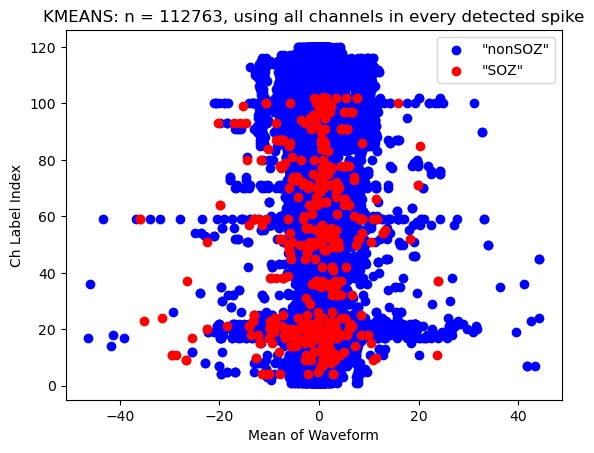

In [38]:
plt.scatter(filtered_label1['mean'], filtered_label1.iloc[:,2001], color= 'blue',alpha=1,label='"nonSOZ"')
plt.scatter(filtered_label0['mean'], filtered_label0.iloc[:,2001], color= 'red',alpha = 1,label='"SOZ"')
plt.legend()
plt.ylabel('Ch Label Index')
plt.xlabel('Mean of Waveform')
plt.title('KMEANS: n = 112763, using all channels in every detected spike')

In [39]:
def plot_scatter_kmeans(spike_values):

    #kcluster of my 1000 spikes raw to check for any "natural states"
    ch_x = range(np.shape(spike_values[0])[1])
    ch_x = [x+1 for x in ch_x]

    values_forone = []
    add_label = []
    for i in range(len(spike_values)):
        spikel = spike_values[i]
        spikel = spikel.transpose()
        for j in range(len(spikel)):
            combine = [spikel[j],ch_x[j]]
            combine2 = np.hstack(combine)
            add_label.append(combine2)
        values_forone.append(add_label)
        add_label = []
        

    values_forone2 = np.concatenate(values_forone,axis=0)

    val_df = pd.DataFrame(values_forone2)
    val_df2 = val_df.dropna(how='any')

    val_df2['mean'] = val_df2.iloc[:,:2001].mean(axis=1)

    raw_kmeans = KMeans(n_clusters=2, random_state=24).fit_predict(val_df2.iloc[:,:2001])

    filtered_label0 = val_df2[raw_kmeans==0]
    filtered_label1 = val_df2[raw_kmeans==1]

    plt.scatter(filtered_label1['mean'], filtered_label1.iloc[:,2001], color= 'blue',alpha=1,label='"nonSOZ"')
    plt.scatter(filtered_label0['mean'], filtered_label0.iloc[:,2001], color= 'red',alpha = 1,label='"SOZ"')
    plt.legend()
    plt.ylabel('Ch Label Index')
    plt.xlabel('Mean of Waveform')
    plt.title('KMEANS: n = 112763, using all channels in every detected spike')

    return

/var/folders/j3/ps9_bddj0kg0ds3px8t769_00000gn/T/ipykernel_66573/2139633213.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df2['mean'] = val_df2.iloc[:,:2001].mean(axis=1)


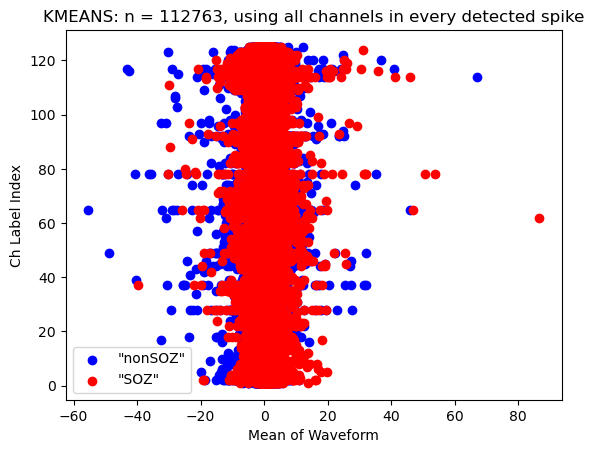

In [40]:
data_directory = '/Users/carlosaguila/Downloads'
pt_name = 'HUP100'
spike = load_pt(pt_name,data_directory)

plot_scatter_kmeans(spike.values)

/var/folders/j3/ps9_bddj0kg0ds3px8t769_00000gn/T/ipykernel_66573/2139633213.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df2['mean'] = val_df2.iloc[:,:2001].mean(axis=1)


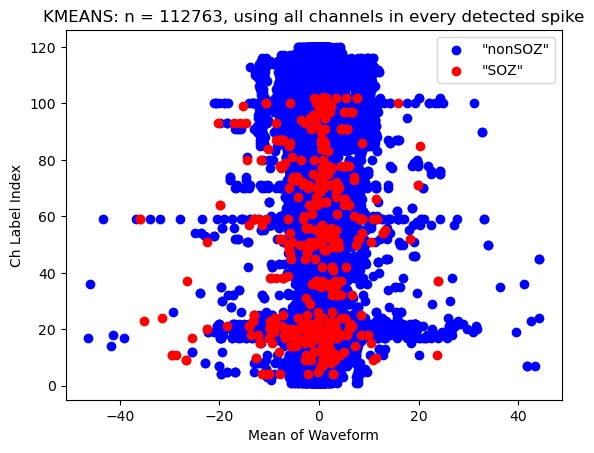

In [41]:
data_directory = '/Users/carlosaguila/Downloads'
pt_name = 'HUP101'
spike = load_pt(pt_name,data_directory)

plot_scatter_kmeans(spike.values)

/var/folders/j3/ps9_bddj0kg0ds3px8t769_00000gn/T/ipykernel_66573/2139633213.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df2['mean'] = val_df2.iloc[:,:2001].mean(axis=1)


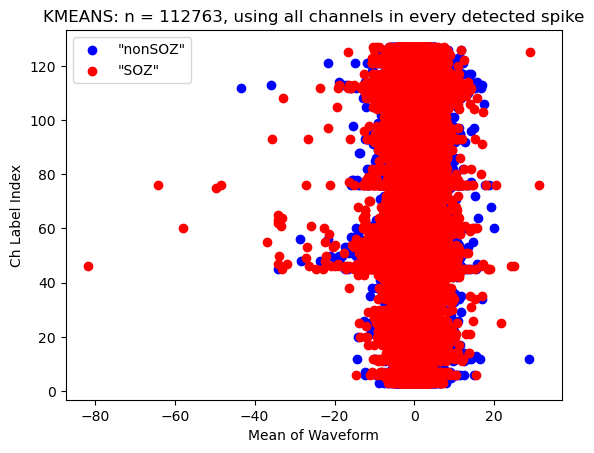

In [42]:
data_directory = '/Users/carlosaguila/Downloads'
pt_name = 'HUP102'
spike = load_pt(pt_name,data_directory)

plot_scatter_kmeans(spike.values)

/var/folders/j3/ps9_bddj0kg0ds3px8t769_00000gn/T/ipykernel_66573/2139633213.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df2['mean'] = val_df2.iloc[:,:2001].mean(axis=1)


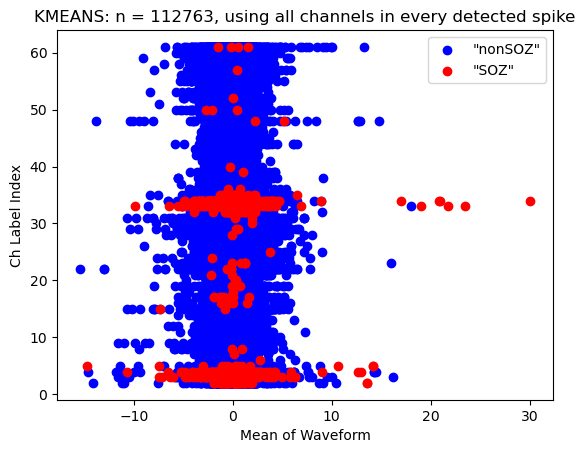

In [43]:
data_directory = '/Users/carlosaguila/Downloads'
pt_name = 'HUP105'
spike = load_pt(pt_name,data_directory)

plot_scatter_kmeans(spike.values)

/var/folders/j3/ps9_bddj0kg0ds3px8t769_00000gn/T/ipykernel_66573/2139633213.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df2['mean'] = val_df2.iloc[:,:2001].mean(axis=1)


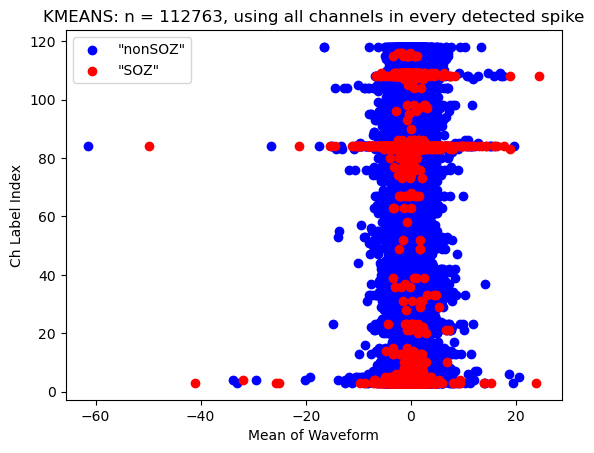

In [44]:
data_directory = '/Users/carlosaguila/Downloads'
pt_name = 'HUP106'
spike = load_pt(pt_name,data_directory)

plot_scatter_kmeans(spike.values)

/var/folders/j3/ps9_bddj0kg0ds3px8t769_00000gn/T/ipykernel_66573/2139633213.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df2['mean'] = val_df2.iloc[:,:2001].mean(axis=1)


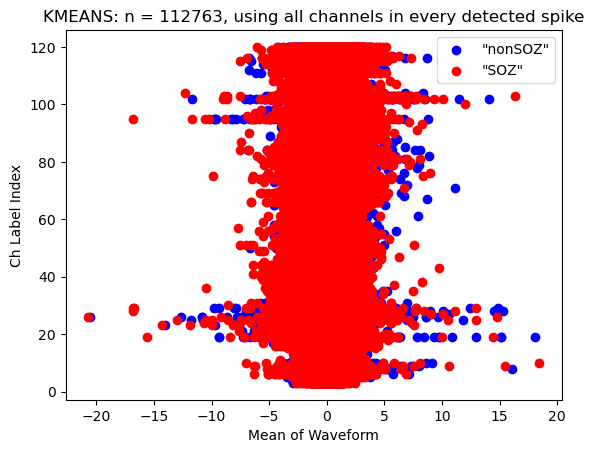

In [45]:
data_directory = '/Users/carlosaguila/Downloads'
pt_name = 'HUP107'
spike = load_pt(pt_name,data_directory)

plot_scatter_kmeans(spike.values)

In [ ]:
#write a code that looks at channel names and determines if it's a grid/strip/depth electrode.

